# Sat Image Processing

The following notebook will grab satellite images and process them. This involves:

- Computing the NDVI, GCI and Water Indexes for each image.
- Plotting them and saving them.
- Computing the average indexes for each DoY 
- Dividing the images into cell and computing the average indexes for each DoY.
- Maybe rotate them?

In [50]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
import geodatasets
from shapely.geometry import box  # Import box to create a bounding box geometry
import contextily as ctx
import pyproj
import numpy as np

TIF Bounds: BoundingBox(left=-121.50646413187638, bottom=36.981878962687844, right=-121.49509979431059, top=36.9893690942653)


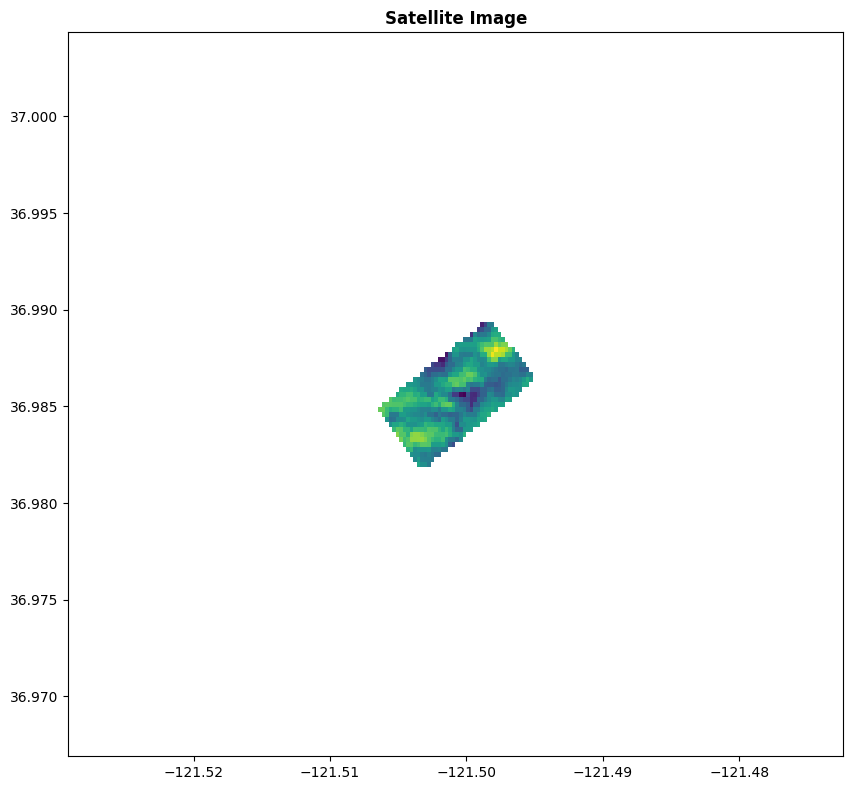

In [66]:

# Open the TIF file using rasterio
tif_path = './data/sat_images/2024-10-06_13-49-16/doy2021337_B5.tif'
shapefile_path = "./data/countries_data_set/ne_110m_admin_0_countries.shp"

# Open the TIF file using rasterio
with rasterio.open(tif_path) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    # Plot the TIF image
    show(src, ax=ax, title="Satellite Image")
    
    # Get the bounding box of the TIF image
    tif_bounds = src.bounds
    print(f"TIF Bounds: {tif_bounds}")
    
    # Create a geometry of the TIF bounds (a box)
    tif_box = box(tif_bounds.left, tif_bounds.bottom, tif_bounds.right, tif_bounds.top)

# Load the world country boundaries from the shapefile
world = gpd.read_file(shapefile_path)

# Filter the world data to only the countries that intersect with the TIF bounds
world_clipped = world[world.intersects(tif_box)]

# Plot the boundaries that intersect with the TIF on top of the TIF image
world_clipped.boundary.plot(ax=ax, linewidth=1, color='black')

# Zoom out by expanding the plot limits by 10%
x_margin = (tif_bounds.right - tif_bounds.left) * 2
y_margin = (tif_bounds.top - tif_bounds.bottom) * 2


# Set the plot limits to zoom out slightly
ax.set_xlim([tif_bounds.left - x_margin, tif_bounds.right + x_margin])
ax.set_ylim([tif_bounds.bottom - y_margin, tif_bounds.top + y_margin])

plt.show()

C:\Users\manny\AppData\Local\Temp\ipykernel_19500\3410868869.py:14: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


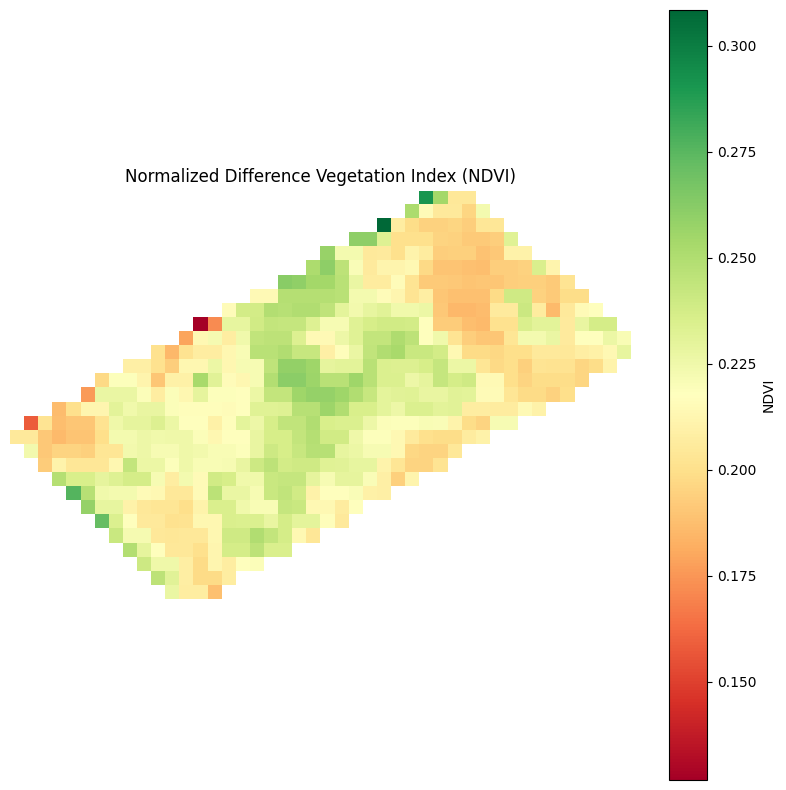

In [67]:
# prompt: Calculate NDVI

# Consider the reflectance scale factor from layer metadata
scale_factor = 2.75e-05

with rasterio.open('./data/sat_images/2024-10-06_13-49-16/doy2024154_B4.tif') as red_band, \
     rasterio.open('./data/sat_images/2024-10-06_13-49-16/doy2024154_B5.tif') as nir_band:

    # Read each band
    red = red_band.read(1).astype('float32') * scale_factor
    nir = nir_band.read(1).astype('float32') * scale_factor

    # Calculate NDVI
    ndvi = (nir - red) / (nir + red) 

    # Plot NDVI
    plt.figure(figsize=(10, 10))
    plt.imshow(ndvi, cmap='RdYlGn')
    plt.colorbar(label='NDVI')
    plt.title('Normalized Difference Vegetation Index (NDVI)')
    plt.axis('off')
    plt.show()

In [85]:
def get_mean_parameters(date):
    # NDVI, GCI, NDWI
    
    with rasterio.open('./data/sat_images/2024-10-06_13-49-16/doy' + date + '_B4.tif') as red_band, \
         rasterio.open('./data/sat_images/2024-10-06_13-49-16/doy' + date + '_B5.tif') as nir_band, \
         rasterio.open('./data/sat_images/2024-10-06_13-49-16/doy' + date + '_B3.tif') as green_band:

        # Read each band
        red = red_band.read(1).astype('float32') * scale_factor
        nir = nir_band.read(1).astype('float32') * scale_factor
        green = green_band.read(1).astype('float32') * scale_factor

        # Calculate NDVI
        ndvi = (nir - red) / (nir + red) 
        gci =  (nir / green) - 1 # (green - red) / (green + red)
        ndwi = (green - nir) / (green + nir) 
        
    return np.nanmean(ndvi), np.nanmean(gci), np.nanmean(ndwi)
        

In [86]:
import os
from datetime import datetime, timedelta



def get_unique_dates_and_raw_strings(directory):
    unique_dates = set()  # Use a set to store unique dates
    raw_date_strings = set()  # Use a set to store raw date strings

    # Iterate through files in the specified directory
    for filename in os.listdir(directory):
        # Check if the filename matches the expected pattern
        if filename.startswith("doy") and filename.endswith(".tif"):
            # Extract the year and day of the year
            year_day = filename[3:10]  # YYYYDDD
            
            # Extract year and day of year
            year = int(year_day[:4])  # YYYY
            day_of_year = int(year_day[4:])  # DDD
            
            # Convert to a date
            date = datetime(year, 1, 1) + timedelta(days=day_of_year - 1)
            unique_dates.add(date.date())  # Add the date to the set
            
            # Add the raw date string (YYYYDDD) to the set
            raw_date_strings.add(year_day)

    # Sort unique dates and create an ordered list of raw date strings
    sorted_unique_dates = sorted(unique_dates)
    ordered_raw_date_strings = [
        f"{date.year}{date.timetuple().tm_yday:03d}"  # Recreate the YYYYDDD format
        for date in sorted_unique_dates
    ]

    return sorted_unique_dates, ordered_raw_date_strings  # Return sorted lists of unique dates and raw date strings


# Specify your directory path here
directory_path = './data/sat_images/2024-10-06_13-49-16/'
unique_dates, raw_date_strings = get_unique_dates_and_raw_strings(directory_path)


In [93]:
all_ndvi = []
all_gci = []
all_ndwi = []

for image_date in raw_date_strings:
    mean_ndvi, mean_gci, mean_ndwi = get_mean_parameters(image_date)
    

C:\Users\manny\AppData\Local\Temp\ipykernel_19500\80149779.py:14: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)
C:\Users\manny\AppData\Local\Temp\ipykernel_19500\80149779.py:15: RuntimeWarning: invalid value encountered in divide
  gci = (green - red) / (green + red) # gci = (nir / green) - 1
C:\Users\manny\AppData\Local\Temp\ipykernel_19500\80149779.py:16: RuntimeWarning: invalid value encountered in divide
  ndwi = (green - nir) / (green + nir)


(np.float32(0.12505454), np.float32(-0.075098835), np.float32(-0.19825298))